In [76]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import theano

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [77]:
this_dat = np.load('taste_data.npy')
print(this_dat.shape)
# Trial x Nrn x Time

(30, 10, 7000)


In [78]:
# Convert spikes to counts by binning
time_lims = [2000,4000]
bin_width = 25
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(*this_dat.shape[:-1],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

(30, 10, 80)


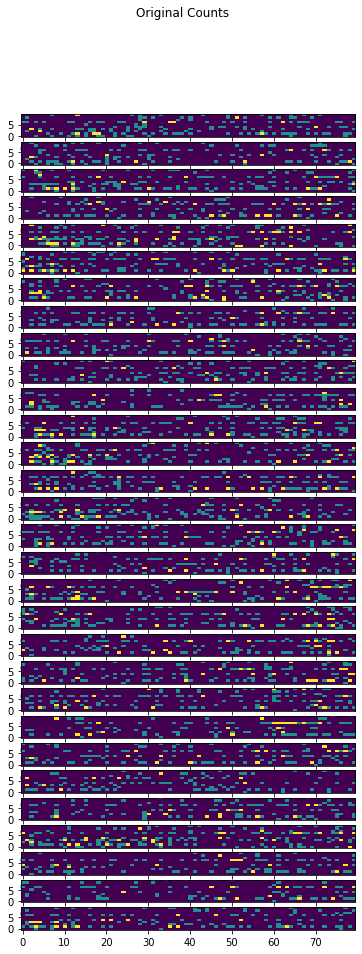

In [79]:
# Pick single trial
trial = np.arange(this_dat.shape[0])
count_data = this_dat_binned[trial]
#count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]

fig, ax = plt.subplots(len(trial),1, figsize = (6,15))
for this_ax, this_dat in zip(ax.flatten(),count_data):
    this_ax.imshow((this_dat>0)*1 + (this_dat>1), interpolation = 'nearest', aspect = 'auto', origin = 'lower')
plt.suptitle('Original Counts')

count_data = count_data>0
print(count_data.shape)
# Nrn X Time_bin

In [80]:
states = 3
split_list = np.array_split(count_data,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
mean_vals = np.mean(split_array,axis=(1,-1))
mean_vals += 0.01 # To avoid zero starting prob
print(mean_vals.shape) # Trials x nrns
print(mean_vals)

(3, 10)
[[0.09205128 0.39589744 0.16897436 0.29717949 0.23692308 0.03051282
  0.34974359 0.04846154 0.09589744 0.12025641]
 [0.05871795 0.30871795 0.15871795 0.09333333 0.27153846 0.01512821
  0.33435897 0.03564103 0.12282051 0.14846154]
 [0.08692308 0.40358974 0.14974359 0.07538462 0.29461538 0.01769231
  0.45487179 0.08820513 0.12923077 0.12153846]]


In [81]:
idx = np.arange(n_count_data) # Index
array_idx = np.broadcast_to(idx, count_data.shape)
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())
print(array_idx.shape)

0
79
(30, 10, 80)


In [82]:

lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    # Defining variables with priors
    #alpha = 1.0/count_data.mean(axis=-1)
    
    # Exponential prior on Poisson rate variable: for every state, for every neuron
    #lambda_1 = pm.Exponential("lambda_1", alpha, testval = mean_vals[0], shape = (count_data.shape[0]))
    #lambda_2 = pm.Exponential("lambda_2", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    #lambda_3 = pm.Exponential("lambda_3", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    
    # SAME LAMBDAS ACROSS ALL TRIALS
    # Finite, but somewhere on the lower end, Beta prior
    #a_lambda = pm.HalfNormal('a_lambda', 2.)
    #b_lambda = pm.HalfNormal('b_lambda', 5.)
    a_lambda = 2
    b_lambda = 5
    
    lambda_latent = pm.math.stack(
                        [pm.Beta(lambda_names[i], a_lambda, b_lambda, testval = mean_vals[i], 
                                   shape = (mean_vals.shape[1])) \
                         for i in range(states)]
    )
    
print(lambda_latent.tag.test_value.shape)
print(lambda_latent.tag.test_value)

(3, 10)
[[0.09205128 0.39589744 0.16897436 0.29717949 0.23692308 0.03051282
  0.34974359 0.04846154 0.09589744 0.12025641]
 [0.05871795 0.30871795 0.15871795 0.09333333 0.27153846 0.01512821
  0.33435897 0.03564103 0.12282051 0.14846154]
 [0.08692308 0.40358974 0.14974359 0.07538462 0.29461538 0.01769231
  0.45487179 0.08820513 0.12923077 0.12153846]]


In [83]:
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)
print(even_switches)
print(even_switches_normal[1:(states)])

[ 0.         26.33333333 52.66666667 79.        ]
[0.33333333 0.66666667]


In [84]:
tau_names = ['tau_{}'.format(i+1) for i in range(count_data.shape[0])]
with model:
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a1 = pm.HalfNormal('a_tau1', 3.)
    #b1 = pm.HalfNormal('b_tau1', 6.)
    #a2 = pm.HalfNormal('a_tau2', 3.)
    #b2 = pm.HalfNormal('b_tau2', 3.)
    #tau_latent1 = pm.Beta('tau_latent1', a1, b1)
    #tau_latent2 = pm.Beta('tau_latent2', a2, b2)
    #tau_1 = pm.Deterministic('tau_1', idx.min() + (idx.max() - idx.min()) * tau_latent1)
    #tau_2 = pm.Deterministic('tau_2', tau_1 + (idx.max() - idx.min()) * tau_latent2)
    #tau = pm.math.stack(tau_1,tau_2)
    
    # INDEPENDENT TAU FOR EVERY TRIAL
    a = pm.HalfNormal('a_tau', 3.)
    b = pm.HalfNormal('b_tau', 3.)
    
    # Define transforms
    Order = pm.transforms.Ordered() # The usual one that pymc3 automatically applies to bounded variables
    Logodd = pm.transforms.LogOdds() # So that one changepoint is always ahead of the other
    chain_tran = pm.transforms.Chain([Logodd, Order])
    if states > 2:
        tau_latent = \
                pm.math.stack([
                        pm.Beta(tau_names[i], a, b,
                              shape = states-1, transform = chain_tran, 
                                testval = even_switches_normal[1:states]) \
                    for i in range(count_data.shape[0])])
    else:
        tau_latent = pm.Beta('tau_latent', a, b, shape = count_data.shape[0], testval = even_switches_normal[1])   
        
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    #tau = pm.DiscreteUniform('tau',lower = idx.min(),upper = idx.max(),
    #                         shape = states-1, transform = pm.transforms.Ordered())
    
    # Dirichlet distribution gives state lenghts
    #tau_latent = pm.Dirichlet('tau_latent', np.ones(states))[:3]
    # State lengths converted to switchpoint times
    #tau = pm.Deterministic('tau', idx_range * tt.extra_ops.cumsum(tau_latent)) # Gives end times of states
    
    
#print(tau_latent.tag.test_value)
print(tau.tag.test_value.shape)
print(tau.tag.test_value)
    


(30, 2)
[[26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]
 [26.33333333 52.66666667]]


In [85]:
model.basic_RVs

[lambda_1_logodds__,
 lambda_2_logodds__,
 lambda_3_logodds__,
 a_tau_log__,
 b_tau_log__,
 tau_1_logodds+ordered__,
 tau_2_logodds+ordered__,
 tau_3_logodds+ordered__,
 tau_4_logodds+ordered__,
 tau_5_logodds+ordered__,
 tau_6_logodds+ordered__,
 tau_7_logodds+ordered__,
 tau_8_logodds+ordered__,
 tau_9_logodds+ordered__,
 tau_10_logodds+ordered__,
 tau_11_logodds+ordered__,
 tau_12_logodds+ordered__,
 tau_13_logodds+ordered__,
 tau_14_logodds+ordered__,
 tau_15_logodds+ordered__,
 tau_16_logodds+ordered__,
 tau_17_logodds+ordered__,
 tau_18_logodds+ordered__,
 tau_19_logodds+ordered__,
 tau_20_logodds+ordered__,
 tau_21_logodds+ordered__,
 tau_22_logodds+ordered__,
 tau_23_logodds+ordered__,
 tau_24_logodds+ordered__,
 tau_25_logodds+ordered__,
 tau_26_logodds+ordered__,
 tau_27_logodds+ordered__,
 tau_28_logodds+ordered__,
 tau_29_logodds+ordered__,
 tau_30_logodds+ordered__]

(30, 10, 80)
(30, 10, 80)


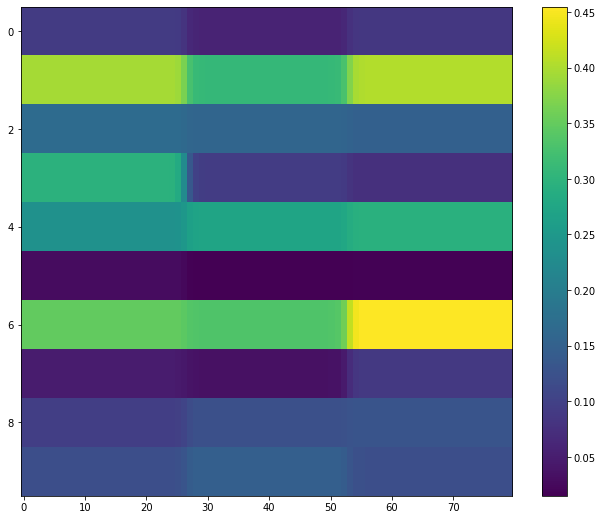

In [91]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    #weight_0 = tt.nnet.sigmoid(2 * (idx - 0))
    #weight_1_stack = pm.math.stack([tt.nnet.sigmoid(2 * (array_idx[0] - tau[i])) for i in range(count_data.shape[0])])
    weight_1_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,0][:,np.newaxis,np.newaxis]))
    weight_2_stack = tt.nnet.sigmoid(2 * (array_idx - tau[:,1][:,np.newaxis,np.newaxis]))
    #lambda_latent_test = np.broadcast_to(lambda_latent[0],count_data.shape)
    lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_1_stack * (1 - weight_2_stack), lambda_latent[1][np.newaxis,:,np.newaxis]) + \
                np.multiply(weight_2_stack, lambda_latent[2][np.newaxis,:,np.newaxis])

print(weight_1_stack.tag.test_value.shape)
print(lambda_.tag.test_value.shape)
plt.imshow(lambda_.tag.test_value[0],aspect='auto');plt.colorbar();

In [92]:
#with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    #weight_0 = tt.nnet.sigmoid(2 * (idx - 0))
    #weight_1_stack = pm.math.stack([tt.nnet.sigmoid(2 * (idx - tau[i])) for i in range(count_data.shape[0])])
    #weight_2_stack = pm.math.stack([tt.nnet.sigmoid(2 * (idx - tau[i][1])) for i in range(count_data.shape[0])])
    #weight_1 = tt.nnet.sigmoid(2 * (idx - tau)) # First state ends at tau[0]
    #weight_2 = tt.nnet.sigmoid(2 * (idx - tau[1])) # Second state ends at tau[1]
    #weight_3 = tt.nnet.sigmoid(2 * (idx - tau[2])) # Third state ends at tau[2]
    #weight_4 = tt.nnet.sigmoid(2 * (idx - tau[3])) # Fourth state ends at tau[3]
    #weight_5 = tt.nnet.sigmoid(2 * (idx - tau[4])) # Fourth state ends at tau[3]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - tau[i])) for i in range(len(tau))]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - 0)))] + weight_list
    
    #test = tt.as_tensor_variable(pm.math.stack([
    #                        1 - weight_1,
    #                        weight_1 * (1 - weight_2),
    #                        weight_2]))
    #print(test.tag.test_value.shape)
    #print(test.value)
    
    #test2 = np.matmul(test.T, lambda_latent)
    
    #lambda_ = pm.math.stack(
    #        [ ((1 - weight_1) * lambda_latent[0][i]) + \
    #          (weight_1 * lambda_latent[1][i])
    #         for i in range(count_data.shape[0])]
    #                )
    
    #lambda_ = pm.math.stack(
    #            [ ((1 - weight_1) * lambda_latent[0][i]) + \
    #              (weight_1 * (1 - weight_2) * lambda_latent[1][i]) + \
    #              (weight_2 * lambda_latent[2][i])
    #             for i in range(count_data.shape[0])]
    #                    )

    #lambda_ = pm.math.stack(
    #    [ [(1 - weight_1_stack[j]) * lambda_latent[0][i] + \
    #      (weight_1_stack[j] * lambda_latent[1][i])
    #      #(weight_2_stack[j] * lambda_latent[2][i])
    #     for i in range(count_data.shape[1])] \
    #            for j in range(count_data.shape[0])]
    #            )
    
    #lambda_ = pm.math.stack(
    #        [ (1 - weight_1) * lambda_latent[0][i] + \
    #          (weight_1  * lambda_latent[1][i]) #+ \
    #          #(weight_2 * (1 - weight_3) * lambda_latent[2][i]) + \
    #          #(weight_3 * (1 - weight_4) * lambda_latent[3][i]) + \
    #          #(weight_4 * (1 - weight_5) * lambda_latent[4][i]) + \
    #          #weight_5  * lambda_latent[5][i]
    #         for i in range(count_data.shape[0])]
    #                )
    
    #weight_vec = pm.math.stack([1 - weight_1,
    #                            weight_1 * (1 - weight_2),
    #                            weight_3])
    #print(weight_vec.T.tag.test_value.shape)
    #print(lambda_latent.T.tag.test_value.shape)
    #lambda_ = pm.math.stack(
    #                    theano.scan(fn = lambda nrn : weight_vec.T*nrn, sequences = [lambda_latent.T]))
    #lambda_ = pm.math.stack(pm.math.dot(weight_vec.T, lambda_latent[:,0]))
    

In [93]:
# Using Bernoullo likelihood for count data
with model:
    observation = pm.Bernoulli("obs", lambda_, observed=count_data)

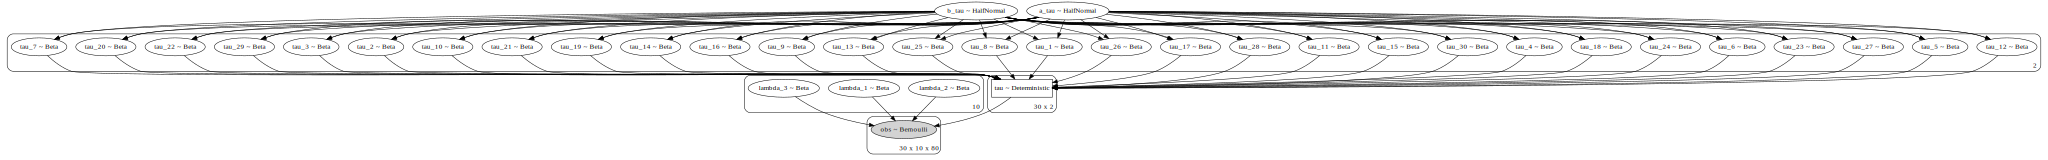

In [94]:
pm.model_to_graphviz(model)

In [95]:
with model:
    #step= pm.Metropolis()
    trace = pm.sample(2000, tune=1000, 
                      step = step,
                      chains = 4, cores = 4)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_30]
>Metropolis: [tau_29]
>Metropolis: [tau_28]
>Metropolis: [tau_27]
>Metropolis: [tau_26]
>Metropolis: [tau_25]
>Metropolis: [tau_24]
>Metropolis: [tau_23]
>Metropolis: [tau_22]
>Metropolis: [tau_21]
>Metropolis: [tau_20]
>Metropolis: [tau_19]
>Metropolis: [tau_18]
>Metropolis: [tau_17]
>Metropolis: [tau_16]
>Metropolis: [tau_15]
>Metropolis: [tau_14]
>Metropolis: [tau_13]
>Metropolis: [tau_12]
>Metropolis: [tau_11]
>Metropolis: [tau_10]
>Metropolis: [tau_9]
>Metropolis: [tau_8]
>Metropolis: [tau_7]
>Metropolis: [tau_6]
>Metropolis: [tau_5]
>Metropolis: [tau_4]
>Metropolis: [tau_3]
>Metropolis: [tau_2]
>Metropolis: [tau_1]
>Metropolis: [b_tau]
>Metropolis: [a_tau]
>Metropolis: [lambda_3]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [06:00<00:00, 33.30draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.

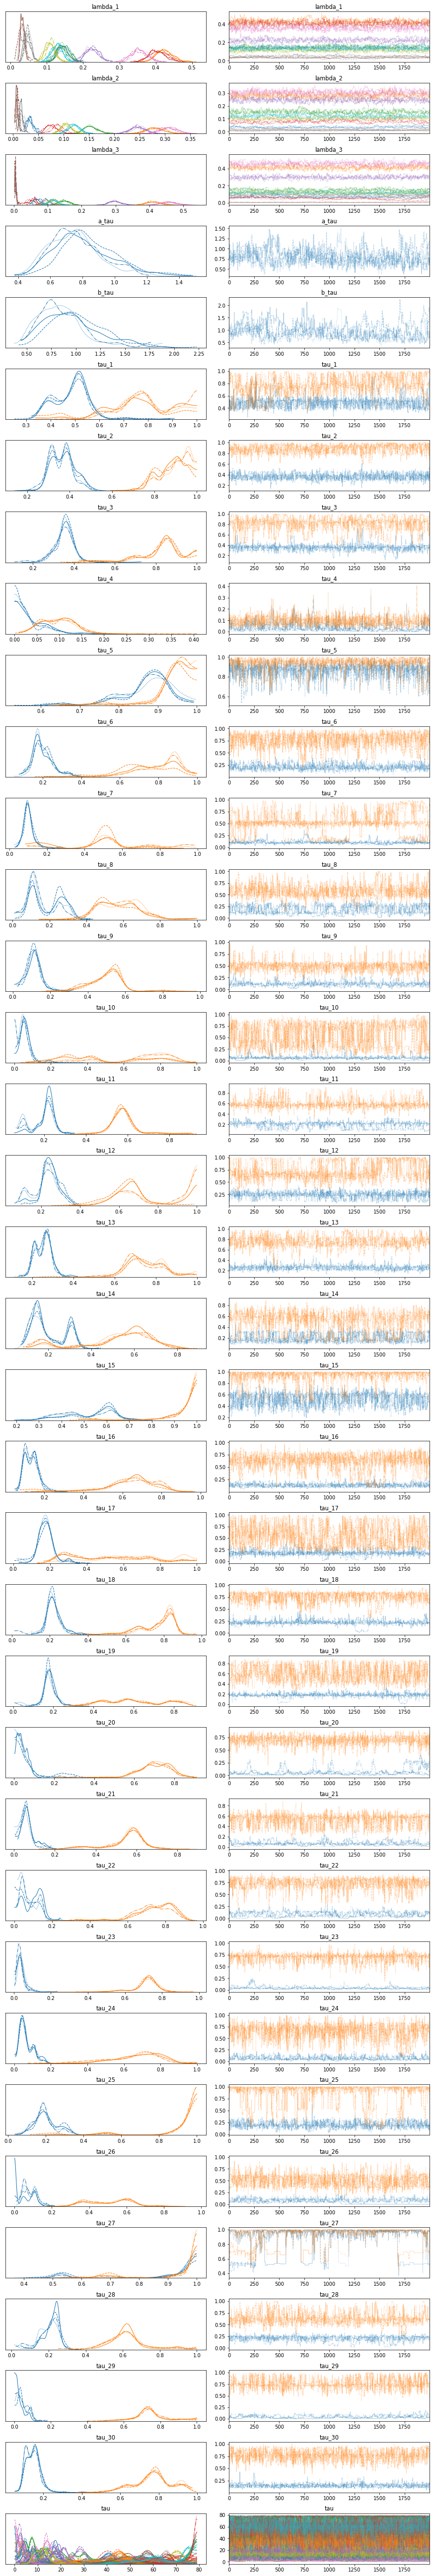

In [96]:
pm.traceplot(trace);

In [97]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_1[0],0.15,0.02,0.11,0.18,0.00,0.00,78.0,78.0,78.0,222.0,1.04
lambda_1[1],0.42,0.02,0.38,0.47,0.00,0.00,211.0,205.0,221.0,365.0,1.02
lambda_1[2],0.14,0.02,0.11,0.18,0.00,0.00,80.0,76.0,84.0,238.0,1.05
lambda_1[3],0.41,0.02,0.36,0.45,0.00,0.00,333.0,333.0,336.0,692.0,1.02
lambda_1[4],0.22,0.02,0.19,0.26,0.00,0.00,222.0,222.0,221.0,443.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
"tau[27,1]",49.21,8.75,35.55,71.13,0.45,0.32,381.0,381.0,437.0,466.0,1.01
"tau[28,0]",3.19,2.37,0.04,7.28,0.28,0.20,73.0,73.0,44.0,23.0,1.08
"tau[28,1]",59.16,7.49,48.18,79.00,0.39,0.28,373.0,361.0,344.0,685.0,1.02
"tau[29,0]",11.49,2.88,6.91,16.12,0.11,0.08,634.0,634.0,652.0,926.0,1.01


In [106]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
lambda_3_samples = trace['lambda_3']
#lambda_4_samples = trace['lambda_4']
lambda_stack = np.stack([lambda_1_samples,
                            lambda_2_samples,
                            lambda_3_samples])#,
                            #lambda_4_samples])
#tau_1_samples = trace['tau_1']
#tau_2_samples = trace['tau_2']
#tau_samples = np.stack([tau_1_samples, tau_2_samples])
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(8000, 30, 2)
(3, 8000, 10)


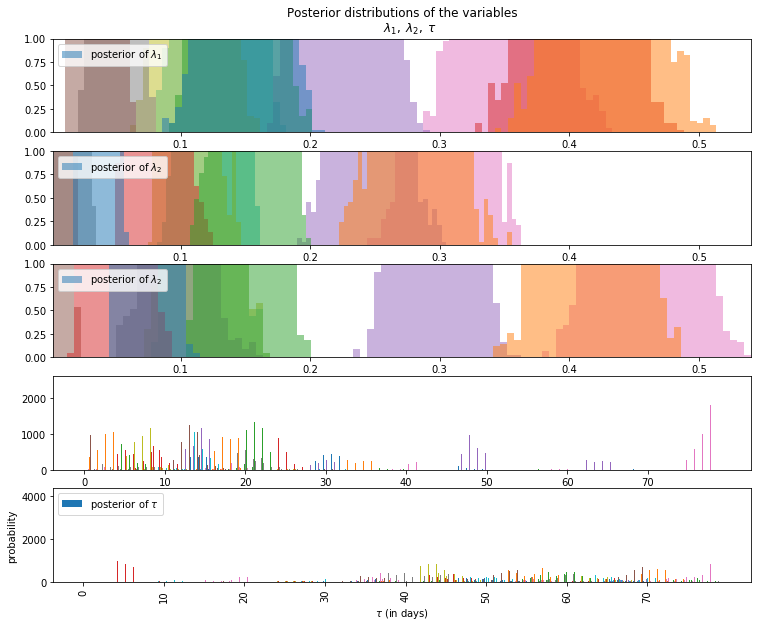

In [108]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(511)
ax.set_autoscaley_on(False)

x_lims = [min(lambda_stack.flatten()),max(lambda_stack.flatten())]
bin_num = 100

plt.hist(lambda_1_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_1$", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim(x_lims)

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

#ax = plt.subplot(514)
#ax.set_autoscaley_on(False)
#plt.hist(lambda_4_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
#         label="posterior of $\lambda_2$", density=True)
#plt.legend(loc="upper left")
#plt.xlabel("$\lambda_2$ value")
#plt.xlim(x_lims)

plt.subplot(514)
plt.hist(tau_samples[...,0], bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$")
plt.xticks(np.arange(n_count_data,step=10))

plt.subplot(515)
plt.hist(tau_samples[...,1], bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$")
plt.xticks(np.arange(n_count_data,step=10))



plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

In [109]:
ppc = pm.sample_posterior_predictive(trace, samples = 200, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:03<00:00, 51.27it/s]


(200, 30, 10, 80)

In [110]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)
print(mean_ppc.shape)

(30, 10, 80)


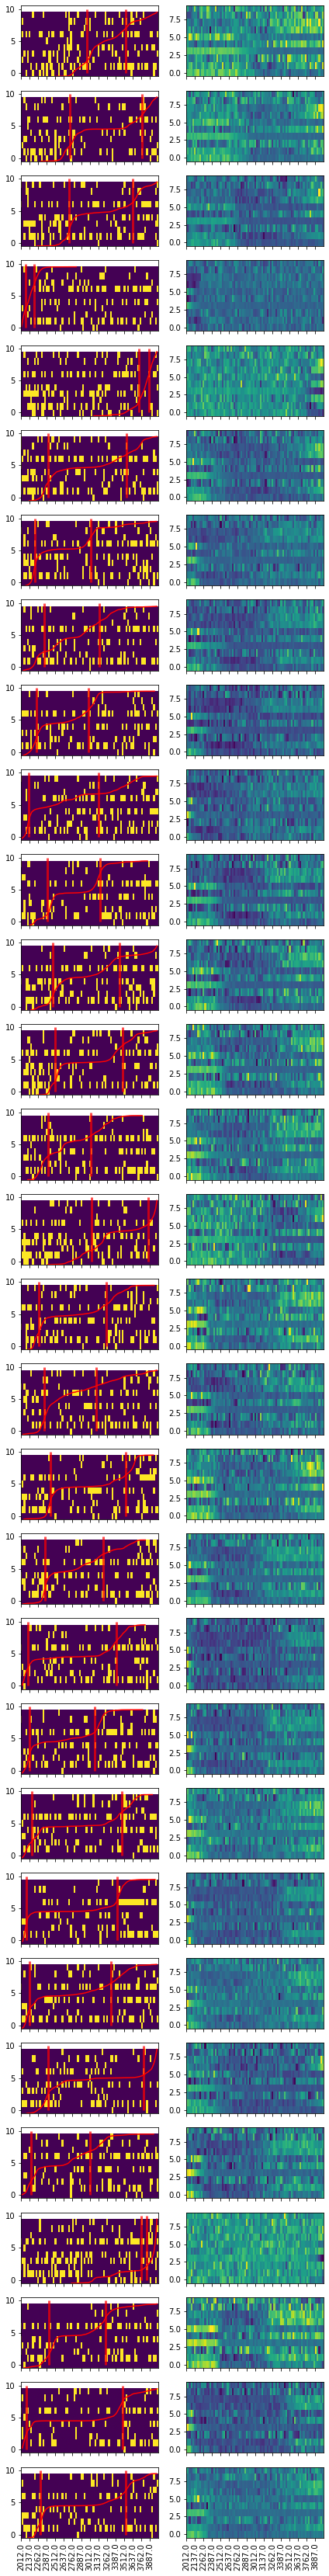

In [115]:
# Overlay raster with CDF of switchpoints
mean_tau = np.mean(tau_samples,axis=0)
tick_interval = 5
fig, ax = plt.subplots(count_data.shape[0],2, figsize = (7,60),sharex=True)
for trial in range(count_data.shape[0]):
    ax[trial,0].imshow(count_data[trial],interpolation='nearest',aspect='auto',origin='lower')
    ax[trial,1].imshow(stats.zscore(mean_ppc[trial],axis=-1),interpolation='nearest',aspect='auto',origin='lower')

    fin_prob,this_x = np.histogram(tau_samples[:,trial].flatten(),100)
    cum_prob = np.cumsum(fin_prob)
    ax[trial,0].plot(this_x[1:],(cum_prob/np.max(cum_prob)*count_data.shape[1])-0.5, c = 'red');
    ax[trial,0].vlines(mean_tau[trial],0,count_data.shape[1],color = 'red',linewidth = 3, alpha = 0.7)

for col in range(2):
    plt.sca(ax[-1,col])
    plt.xticks(np.arange(0,len(binned_t_vec),tick_interval),binned_t_vec[::tick_interval],rotation='vertical');
    plt.xlim(0,len(binned_t_vec))